# 0. Set Up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
from matplotlib.gridspec import GridSpec

In [2]:
# paths

# raw data
data_path = '/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/raw'

# results
results_path = '/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results'


# 1. Data Preprocessing

In [3]:
# load (raw) data – from kaggle
data = pd.read_csv(data_path + '/train.csv')
data.columns, data.shape, data.dtypes

(Index(['property_id', 'city', 'price', 'month', 'year', 'surface_total',
        'surface_covered', 'rooms', 'bedrooms', 'bathrooms', 'property_type',
        'operation_type', 'lat', 'lon', 'title', 'description'],
       dtype='object'),
 (38644, 16),
 property_id         object
 city                object
 price              float64
 month                int64
 year                 int64
 surface_total      float64
 surface_covered    float64
 rooms              float64
 bedrooms             int64
 bathrooms          float64
 property_type       object
 operation_type      object
 lat                float64
 lon                float64
 title               object
 description         object
 dtype: object)

## 1.1. Descriptive Plots & Figures

### 1.1.1. Price distribution

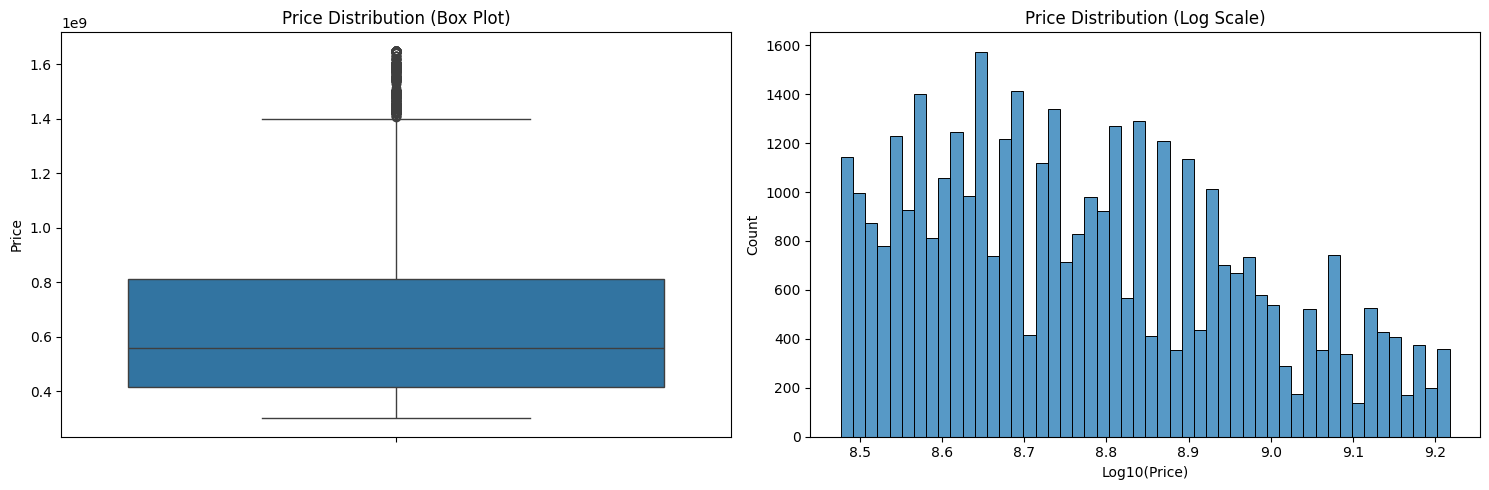

In [4]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Price distribution (box plot)
sns.boxplot(y=data['price'], ax=ax1)
ax1.set_title('Price Distribution (Box Plot)')
ax1.set_ylabel('Price')

# Log-transformed price distribution
sns.histplot(data=data, x=np.log10(data['price']), bins=50, ax=ax2)
ax2.set_title('Price Distribution (Log Scale)')
ax2.set_xlabel('Log10(Price)')

plt.tight_layout()
plt.show()

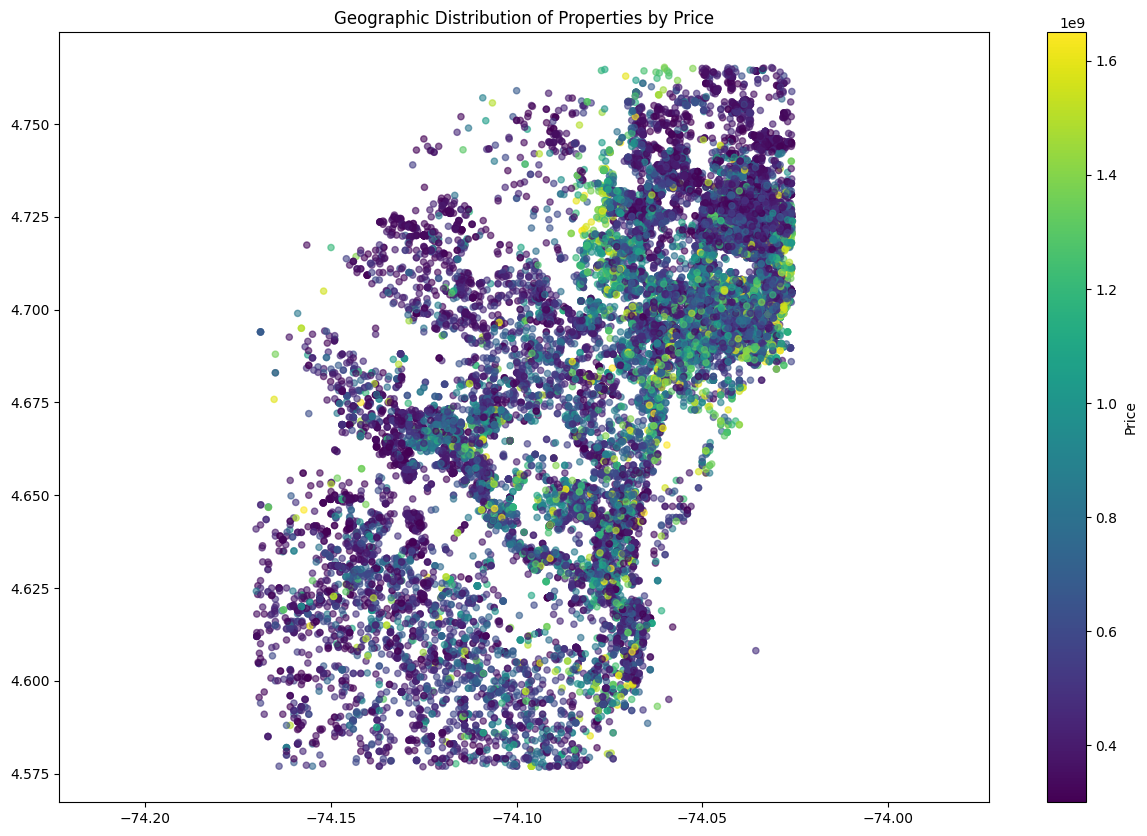

In [5]:
gdf = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data.lon, data.lat)
)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot points colored by price
scatter = gdf.plot(
    ax=ax,
    column='price',
    cmap='viridis',
    legend=True,
    legend_kwds={'label': 'Price'},
    markersize=20,
    alpha=0.6
)

# Customize the plot
ax.set_title('Geographic Distribution of Properties by Price')
plt.axis('equal')

plt.show()

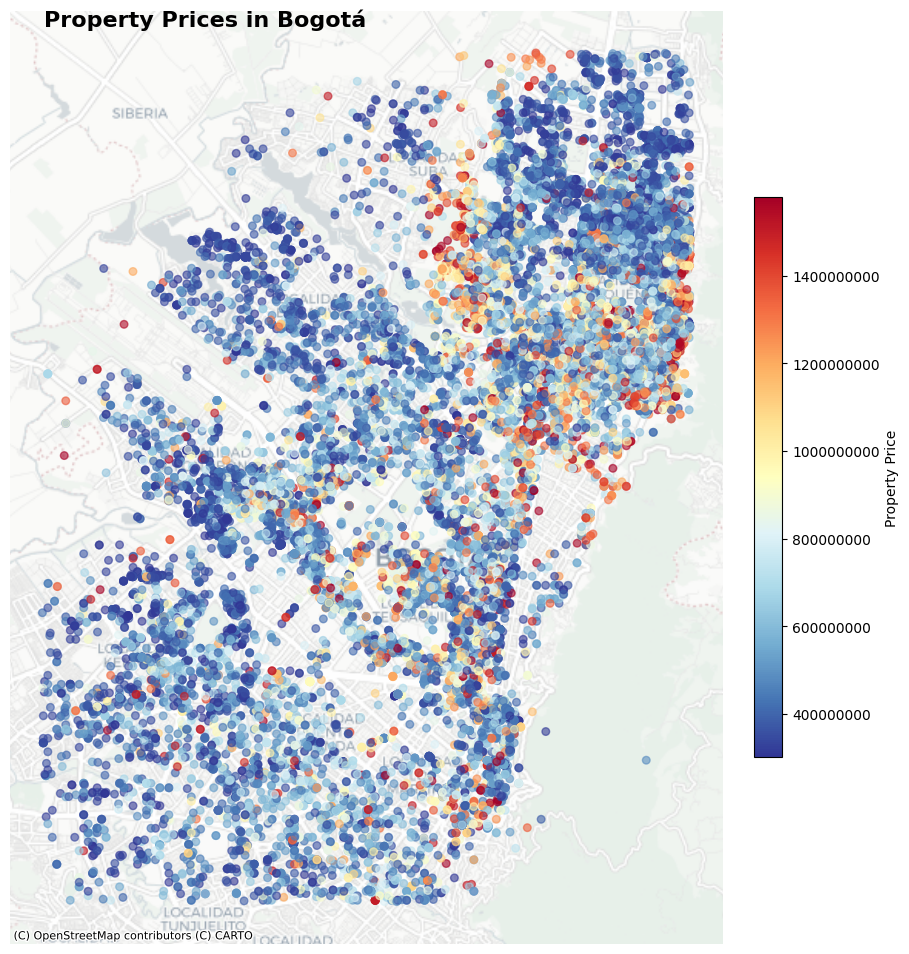

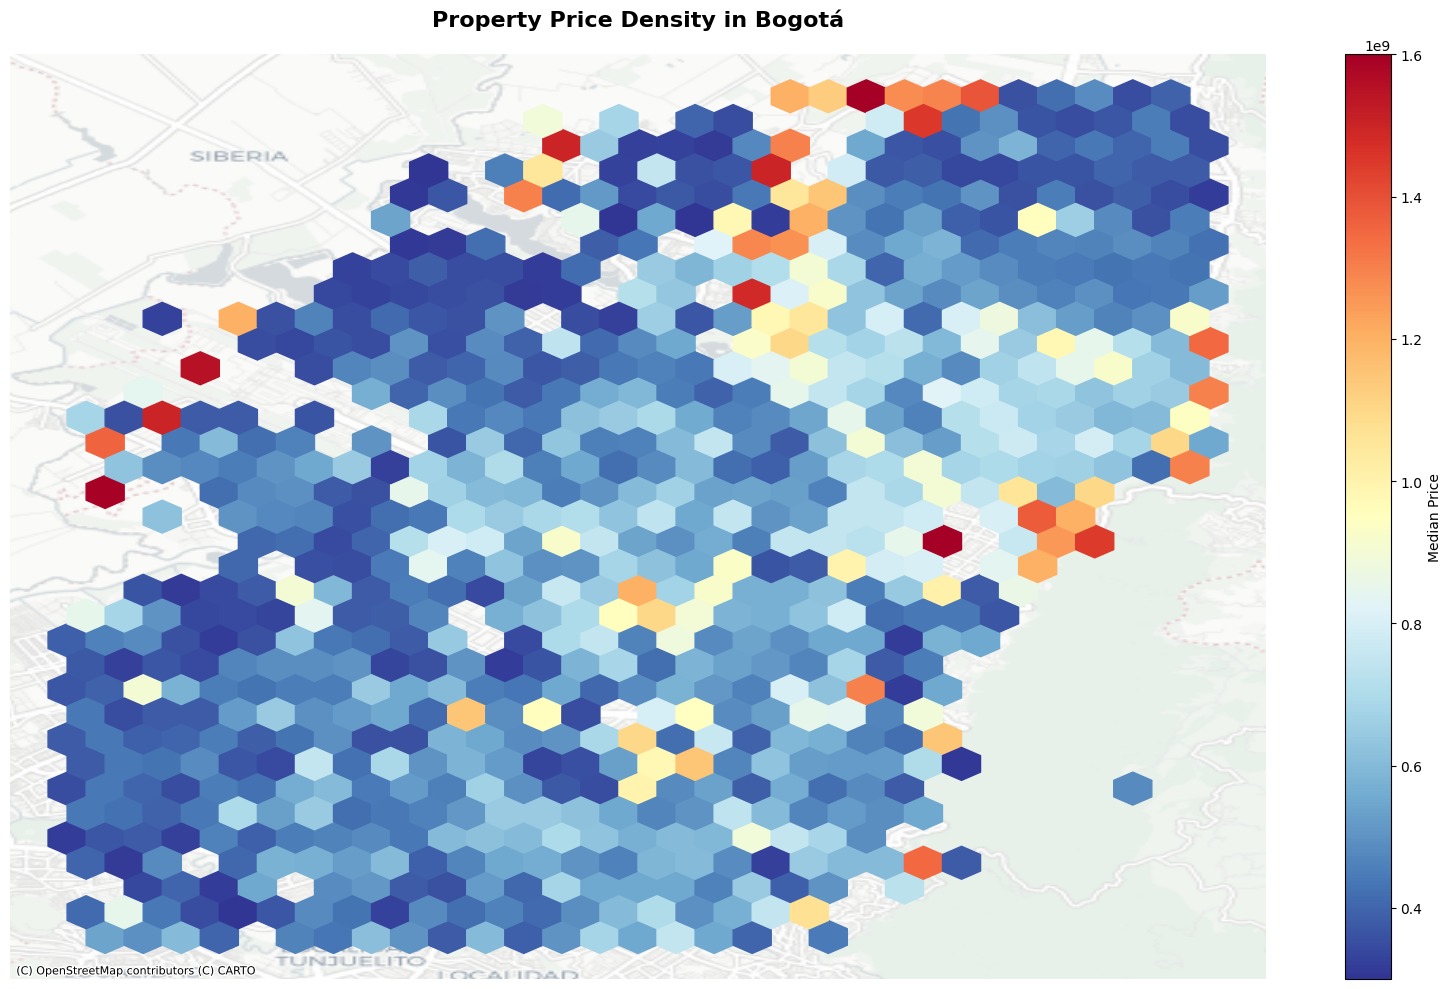

In [6]:
import contextily as ctx

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data.lon, data.lat),
    crs="EPSG:4326"
)
gdf_web = gdf.to_crs(epsg=3857)

# Create figure and axis with specific size ratio
fig, ax = plt.subplots(figsize=(16, 10))

# Calculate price ranges for better color scaling
price_min = gdf['price'].quantile(0.01)  # 1st percentile to avoid extreme outliers
price_max = gdf['price'].quantile(0.99)  # 99th percentile to avoid extreme outliers

# Plot points with improved styling
scatter = gdf_web.plot(
    ax=ax,
    column='price',
    cmap='RdYlBu_r',  # Red-Yellow-Blue reversed (red=expensive, blue=cheap)
    legend=True,
    legend_kwds={
        'label': 'Property Price',
        'orientation': 'vertical',
        'shrink': 0.6,
        'pad': 0.02,
        'format': '%.0f'
    },
    markersize=30,
    alpha=0.6,
    vmin=price_min,
    vmax=price_max
)

# Add a more detailed basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  # Cleaner, more minimal basemap
    zoom=12
)

# Improve title and add subtitle
plt.suptitle('Property Prices in Bogotá', y=0.95, fontsize=16, fontweight='bold')
ax.set_title('', 
             pad=20, fontsize=12, style='italic')

# Remove axes
plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Optional: Create a second visualization showing price density
plt.figure(figsize=(16, 10))
plt.hexbin(
    gdf_web.geometry.x, 
    gdf_web.geometry.y, 
    C=gdf_web['price'],
    gridsize=30,
    cmap='RdYlBu_r',
    reduce_C_function=np.median
)
plt.colorbar(label='Median Price')
ctx.add_basemap(
    plt.gca(),
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)
plt.title('Property Price Density in Bogotá', pad=20, fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

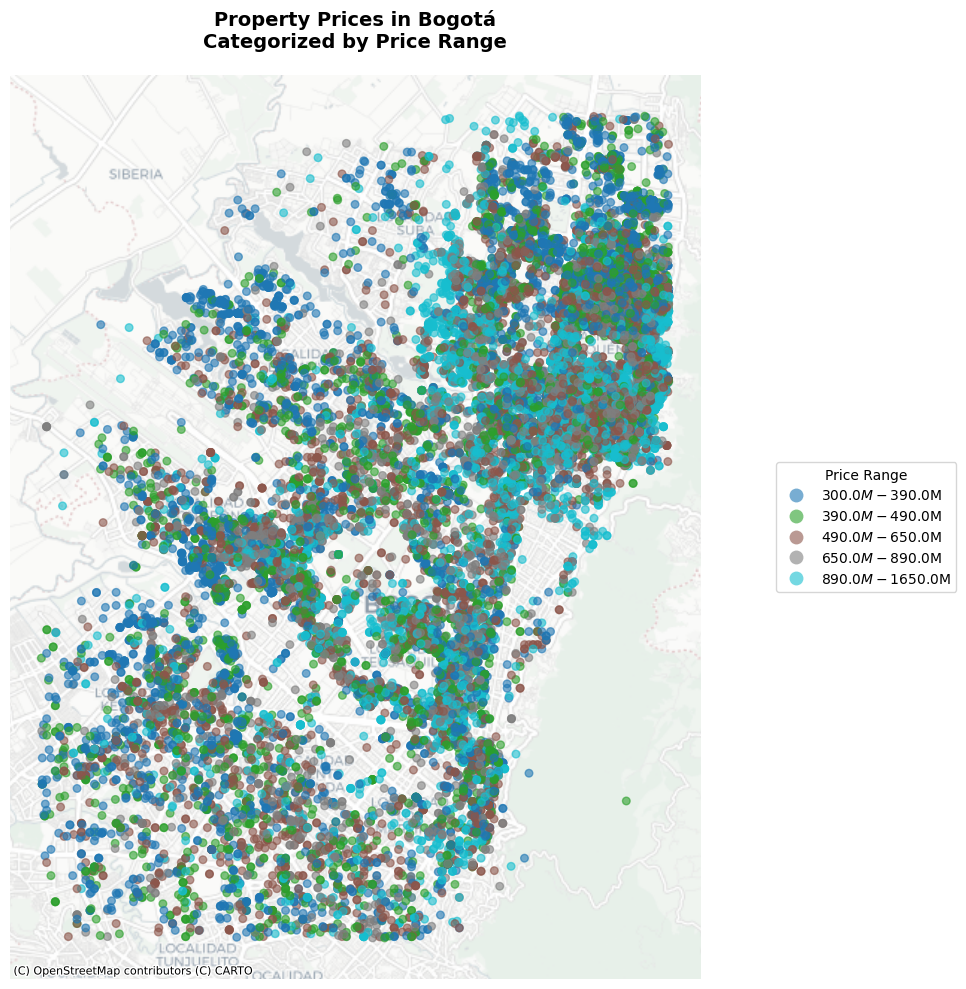


Summary Statistics by Price Category:
                   price                             surface_total rooms
                   count          mean        median          mean  mean
price_category                                                          
$300.0M - $390.0M   8128  3.457665e+08  3.500000e+08        117.52  2.49
$390.0M - $490.0M   7373  4.414613e+08  4.420000e+08        109.72  2.71
$490.0M - $650.0M   8416  5.715800e+08  5.665000e+08        136.15  3.02
$650.0M - $890.0M   7180  7.680252e+08  7.600000e+08        173.07  3.26
$890.0M - $1650.0M  7547  1.179769e+09  1.150000e+09        239.83  3.59


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/3172861847.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = gdf_web.groupby('price_category').agg({


In [7]:
gdf = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data.lon, data.lat),
    crs="EPSG:4326"
)
gdf_web = gdf.to_crs(epsg=3857)

# Create price bins using quantiles
bins = np.quantile(gdf['price'], [0, 0.2, 0.4, 0.6, 0.8, 1.0])
labels = [
    f'${bins[i]/1e6:.1f}M - ${bins[i+1]/1e6:.1f}M' 
    for i in range(len(bins)-1)
]

# Add bin category to the dataframe
gdf_web['price_category'] = pd.cut(
    gdf_web['price'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Create figure
fig, ax = plt.subplots(figsize=(15, 10))

# Plot with categorical colors
scatter = gdf_web.plot(
    ax=ax,
    column='price_category',
    categorical=True,
    legend=True,
    legend_kwds={
        'title': 'Price Range',
        'bbox_to_anchor': (1.1, 0.5),
        'loc': 'center left'
    },
    markersize=30,
    alpha=0.6
)

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

# Title
plt.title('Property Prices in Bogotá\nCategorized by Price Range', 
          pad=20, fontsize=14, fontweight='bold')

# Remove axes
plt.axis('off')

# Adjust layout to make room for legend
plt.tight_layout()
plt.show()

# Print summary statistics for each bin
summary = gdf_web.groupby('price_category').agg({
    'price': ['count', 'mean', 'median'],
    'surface_total': 'mean',
    'rooms': 'mean'
}).round(2)

print("\nSummary Statistics by Price Category:")
print(summary)

### 1.1.2. Correlation matrix

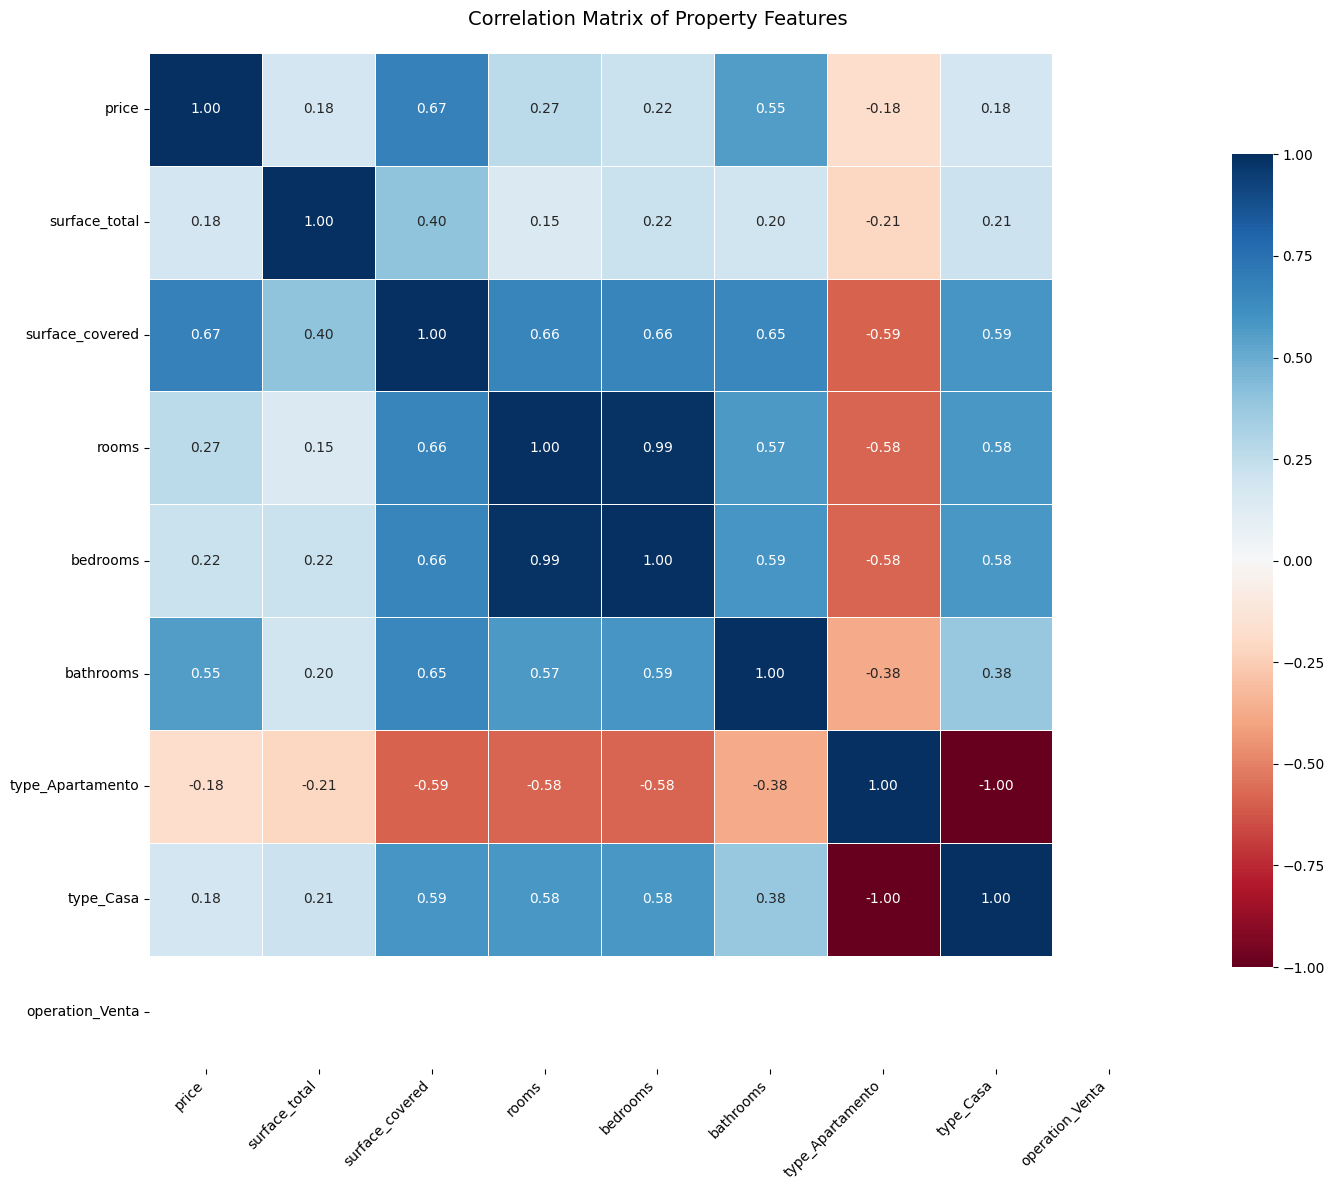

In [8]:
correlation_data = data[['price', 'surface_total', 'surface_covered', 
                        'rooms', 'bedrooms', 'bathrooms', 
                        'property_type', 'operation_type']].copy()

# Convert categorical variables to dummy variables
correlation_data = pd.get_dummies(correlation_data, 
                                columns=['property_type', 'operation_type'],
                                prefix=['type', 'operation'])

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Create a figure with a larger size
plt.figure(figsize=(15, 12))

# Create heatmap with annotations
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='RdBu',  # Red-Blue diverging colormap
            center=0,     # Center the colormap at 0
            fmt='.2f',    # Format annotations to 2 decimal places
            square=True,  # Make cells square
            linewidths=0.5,  # Add grid lines
            cbar_kws={"shrink": .8})  # Adjust colorbar size

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust title and layout
plt.title('Correlation Matrix of Property Features', pad=20, fontsize=14)
plt.tight_layout()
plt.show()

### 1.1.3. Property Type

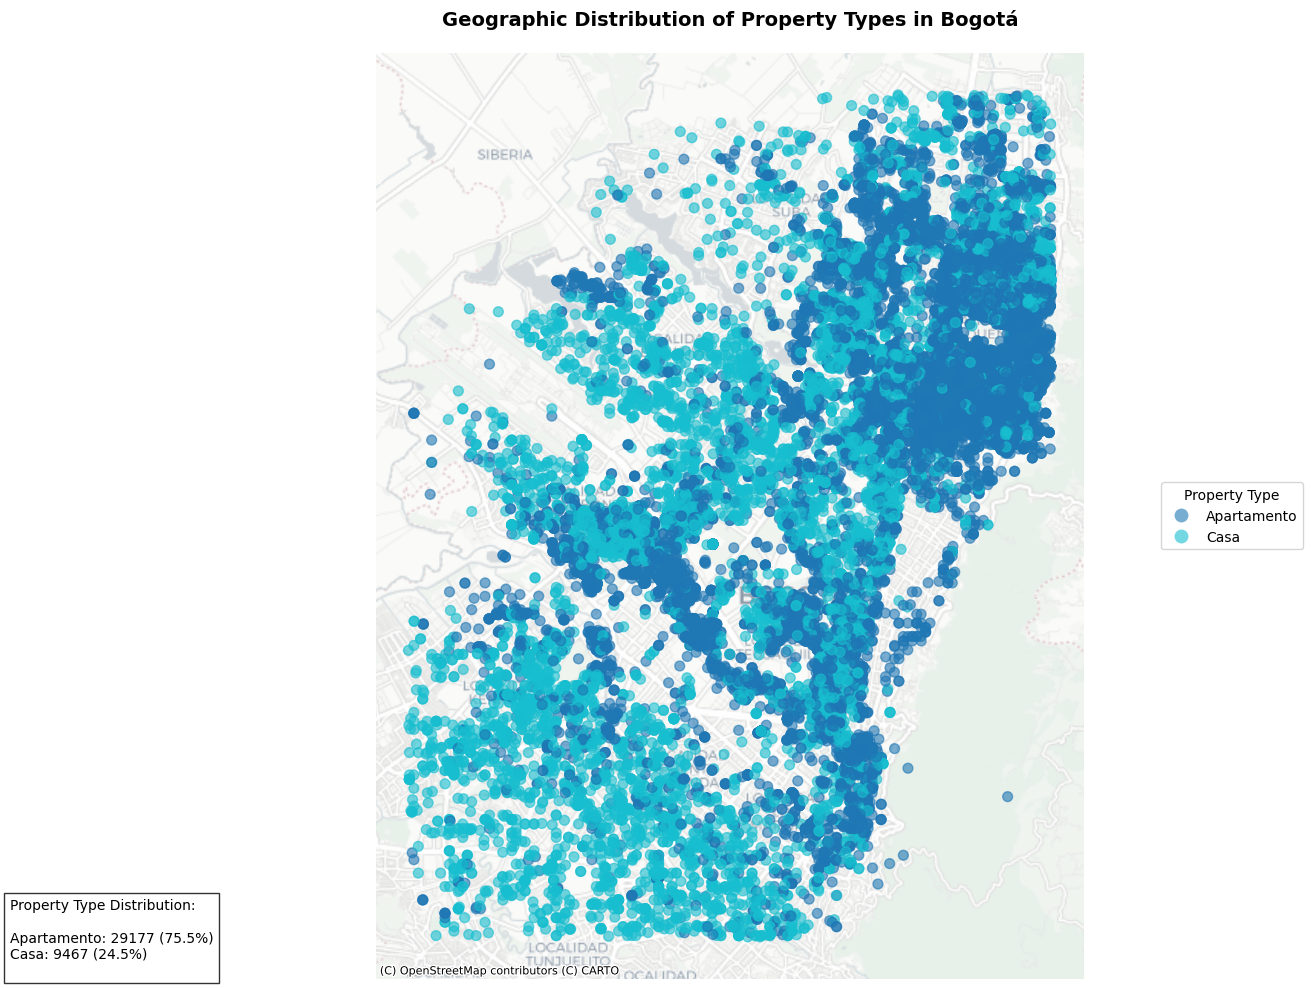

In [9]:
gdf = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data.lon, data.lat),
    crs="EPSG:4326"
)
gdf_web = gdf.to_crs(epsg=3857)

# Create figure with bigger size for better visibility
fig, ax = plt.subplots(figsize=(15, 10))

# Plot properties with different colors by type
scatter = gdf_web.plot(
    ax=ax,
    column='property_type',
    categorical=True,
    legend=True,
    legend_kwds={
        'title': 'Property Type',
        'bbox_to_anchor': (1.1, 0.5),
        'loc': 'center left'
    },
    markersize=50,
    alpha=0.6
)

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

# Title and styling
plt.title('Geographic Distribution of Property Types in Bogotá', 
          pad=20, fontsize=14, fontweight='bold')
plt.axis('off')

# Add summary statistics text box
property_counts = gdf_web['property_type'].value_counts()
total_properties = len(gdf_web)
summary_text = "Property Type Distribution:\n\n"
for prop_type, count in property_counts.items():
    percentage = (count/total_properties) * 100
    summary_text += f"{prop_type}: {count} ({percentage:.1f}%)\n"

plt.figtext(0.02, 0.02, summary_text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=10)

plt.tight_layout()
plt.show()


In [10]:
print("\nDetailed Property Type Statistics:")
stats_df = gdf_web.groupby('property_type').agg({
    'price': ['count', 'mean', 'median'],
    'surface_total': 'mean',
    'rooms': 'mean'
}).round(2)

print("\nBy Property Type:")
print(stats_df)


Detailed Property Type Statistics:

By Property Type:
               price                            surface_total rooms
               count          mean       median          mean  mean
property_type                                                      
Apartamento    29177  6.220662e+08  530000000.0        111.60  2.62
Casa            9467  7.546016e+08  690000000.0        234.71  4.66


### 1.1.4. Time series

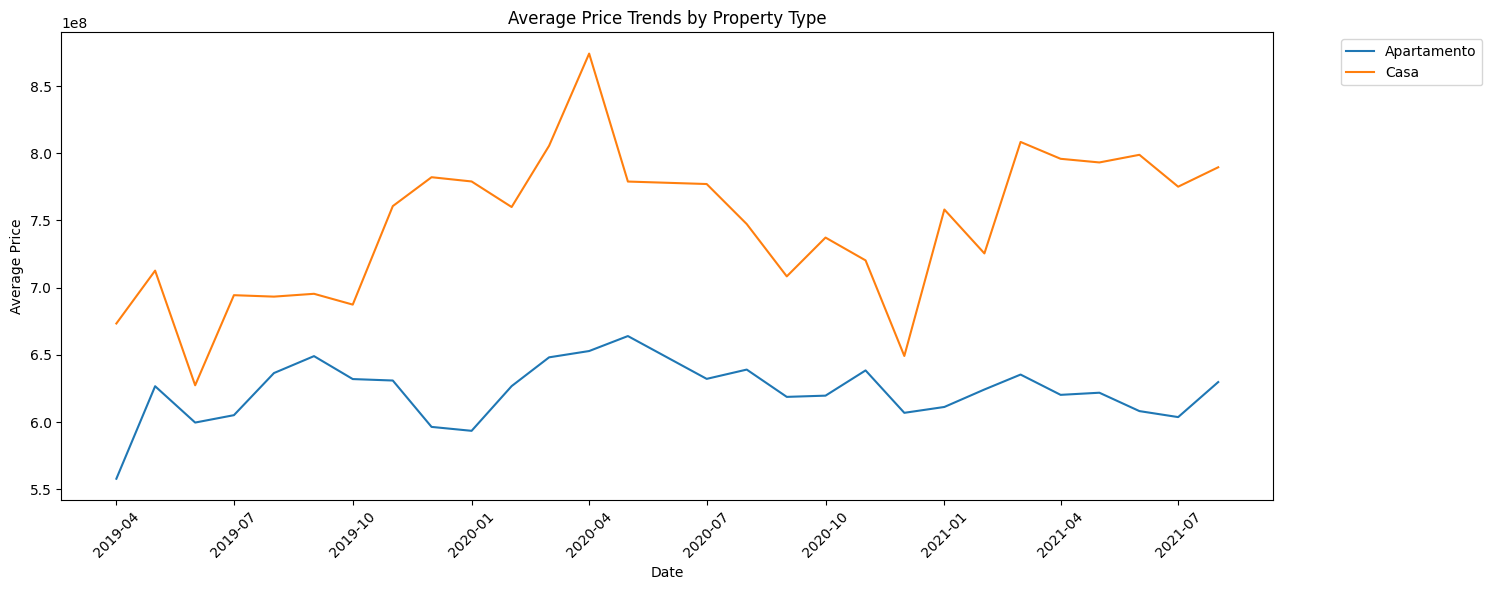

In [11]:
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
monthly_avg = data.groupby(['date', 'property_type'])['price'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=monthly_avg, x='date', y='price', hue='property_type')
plt.title('Average Price Trends by Property Type')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

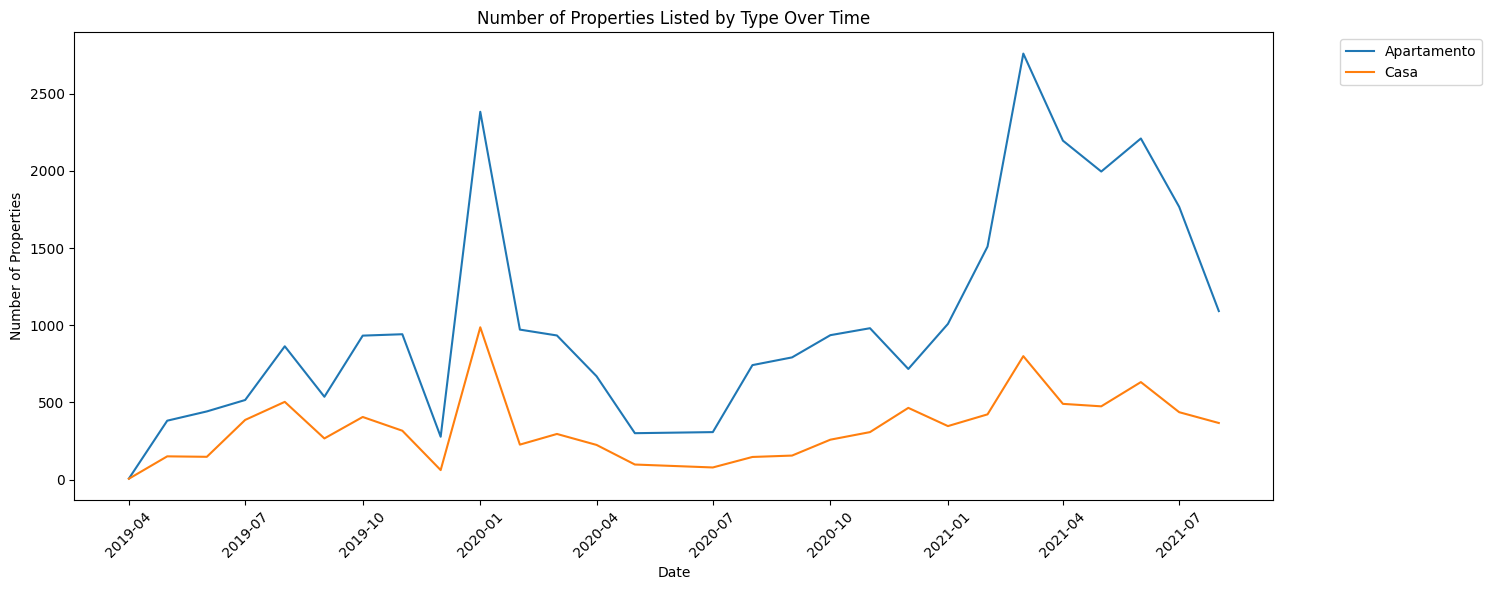

In [12]:
# monthly property count

plt.figure(figsize=(15, 6))
monthly_count = data.groupby(['date', 'property_type']).size().reset_index(name='count')
sns.lineplot(data=monthly_count, x='date', y='count', hue='property_type')
plt.title('Number of Properties Listed by Type Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

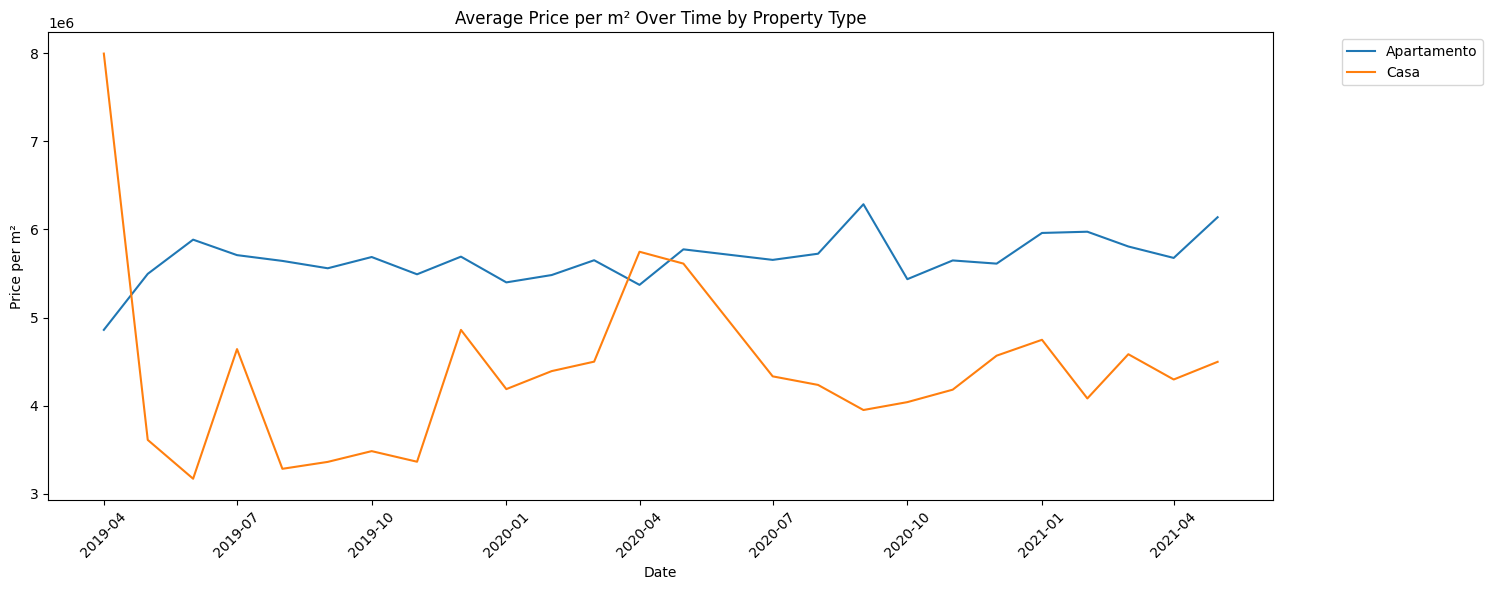

In [13]:
# price per square meter (over time)
data['price_per_m2'] = data['price'] / data['surface_total']
monthly_price_m2 = data.groupby(['date', 'property_type'])['price_per_m2'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=monthly_price_m2, x='date', y='price_per_m2', hue='property_type')
plt.title('Average Price per m² Over Time by Property Type')
plt.xlabel('Date')
plt.ylabel('Price per m²')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

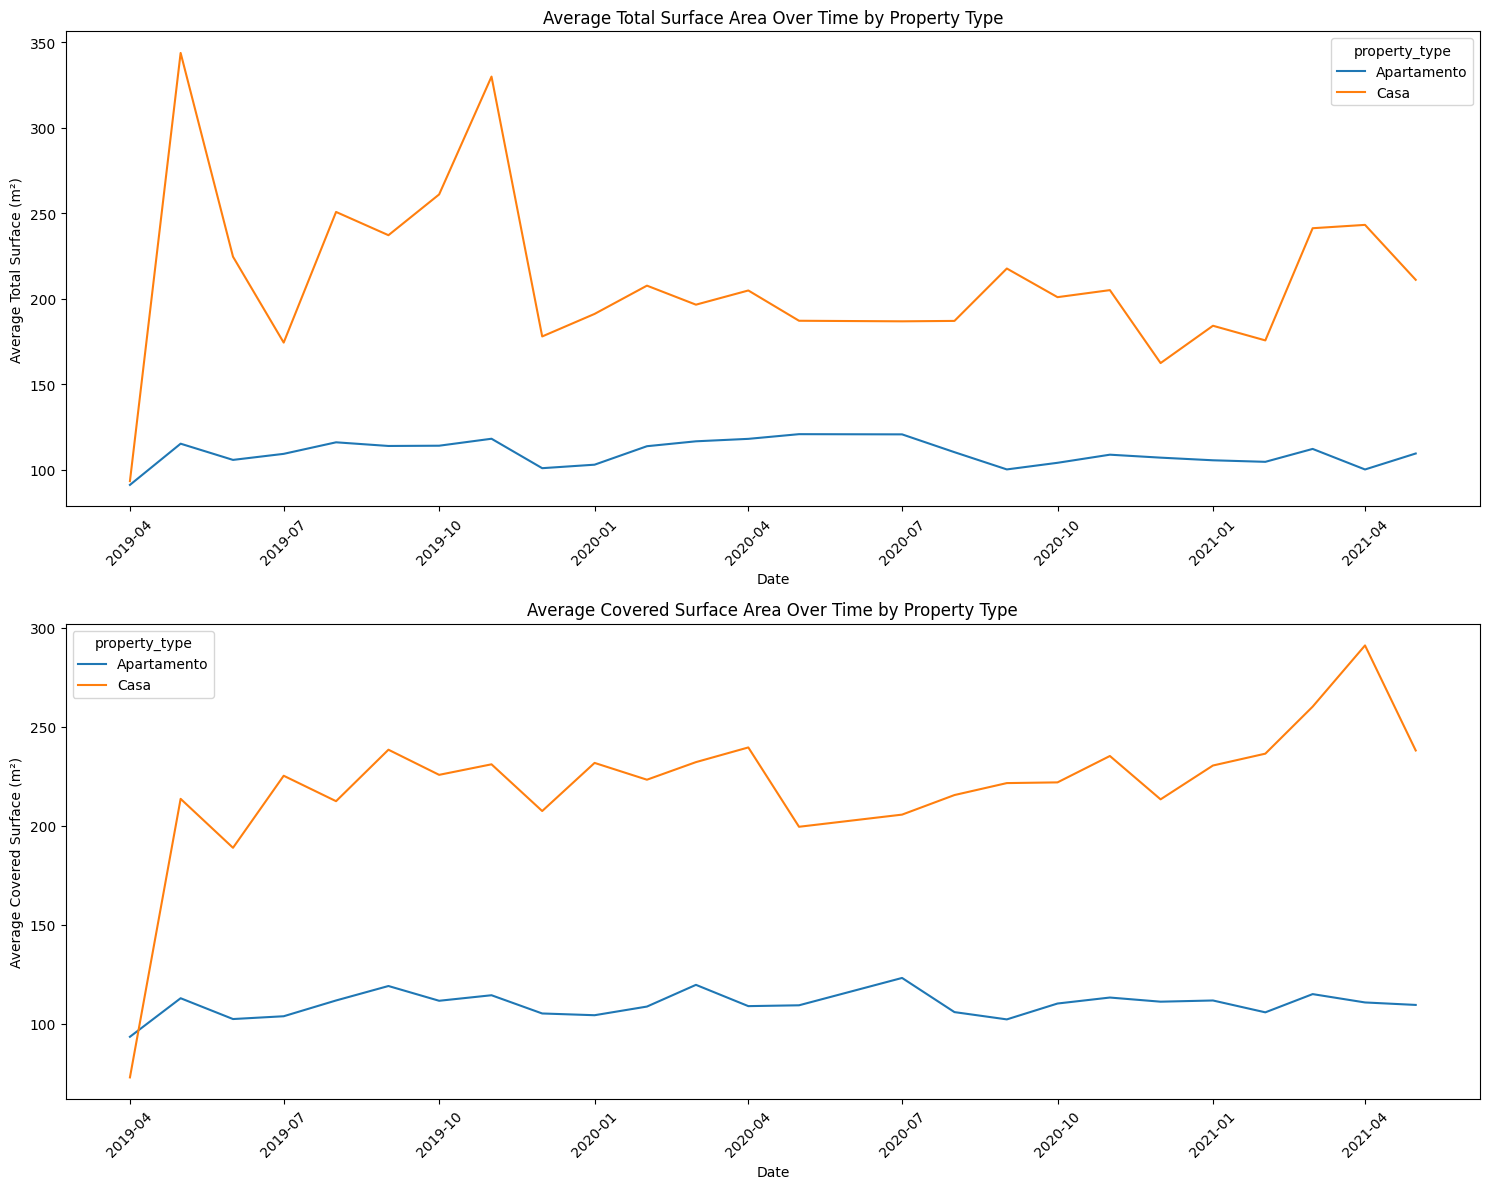

In [14]:
# 5. Property Size Over Time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Average total surface
monthly_surface = data.groupby(['date', 'property_type'])['surface_total'].mean().reset_index()
sns.lineplot(data=monthly_surface, x='date', y='surface_total', hue='property_type', ax=ax1)
ax1.set_title('Average Total Surface Area Over Time by Property Type')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Total Surface (m²)')
ax1.tick_params(axis='x', rotation=45)

# Average covered surface
monthly_covered = data.groupby(['date', 'property_type'])['surface_covered'].mean().reset_index()
sns.lineplot(data=monthly_covered, x='date', y='surface_covered', hue='property_type', ax=ax2)
ax2.set_title('Average Covered Surface Area Over Time by Property Type')
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Covered Surface (m²)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/2479336791.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


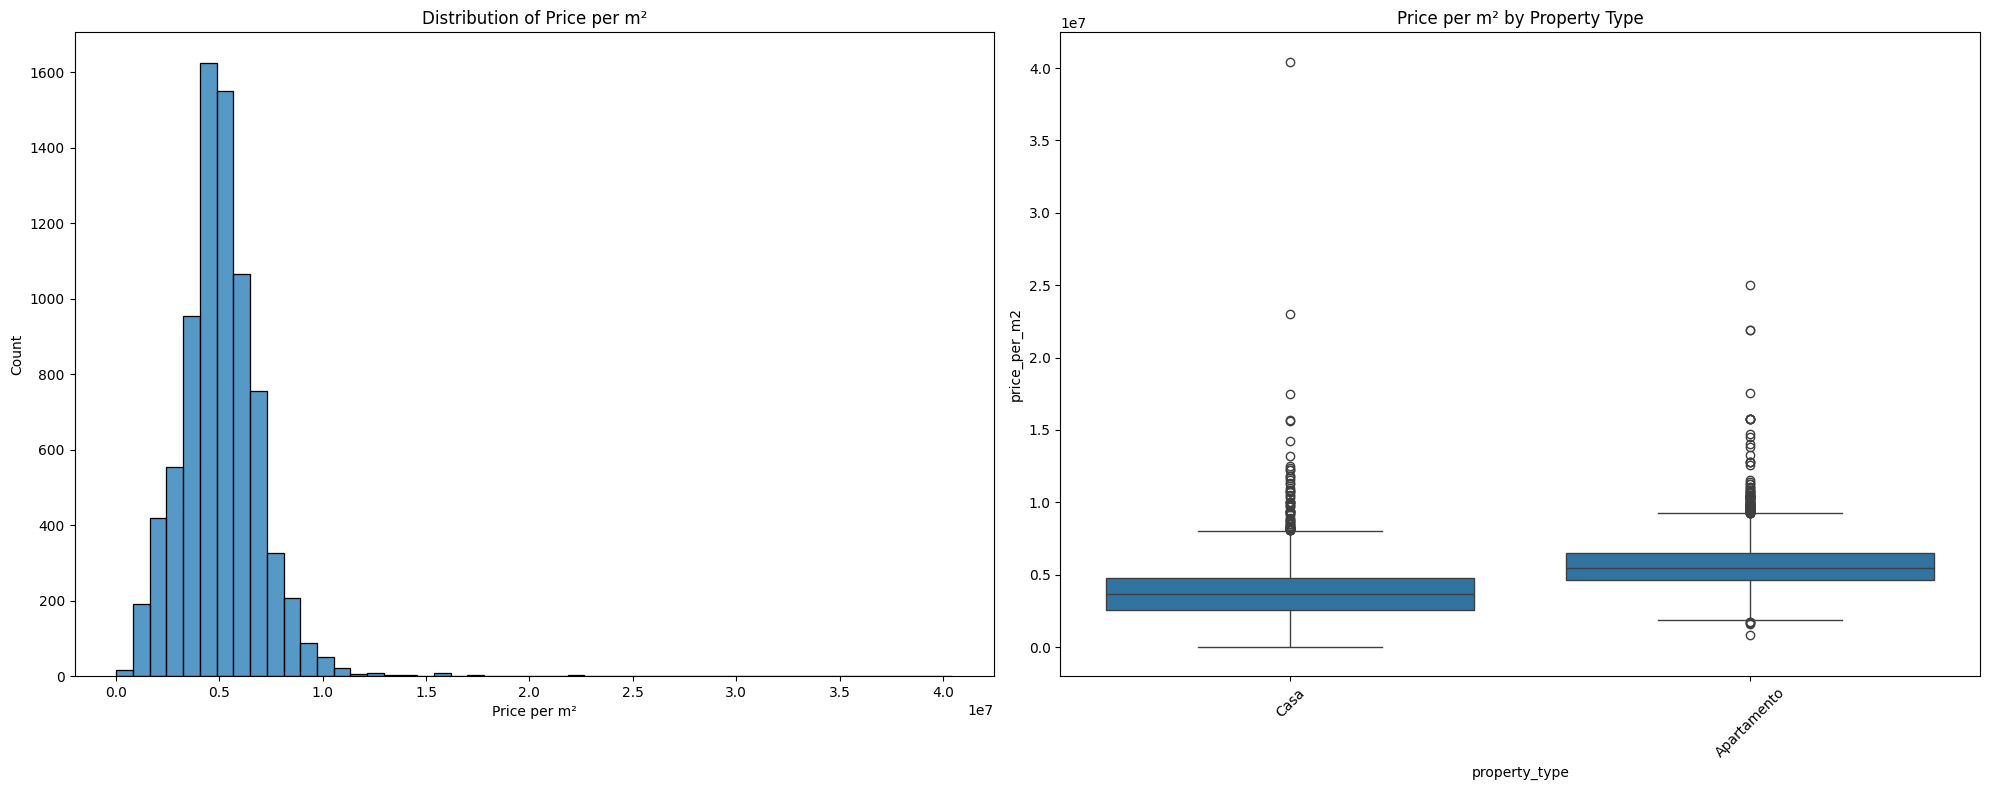

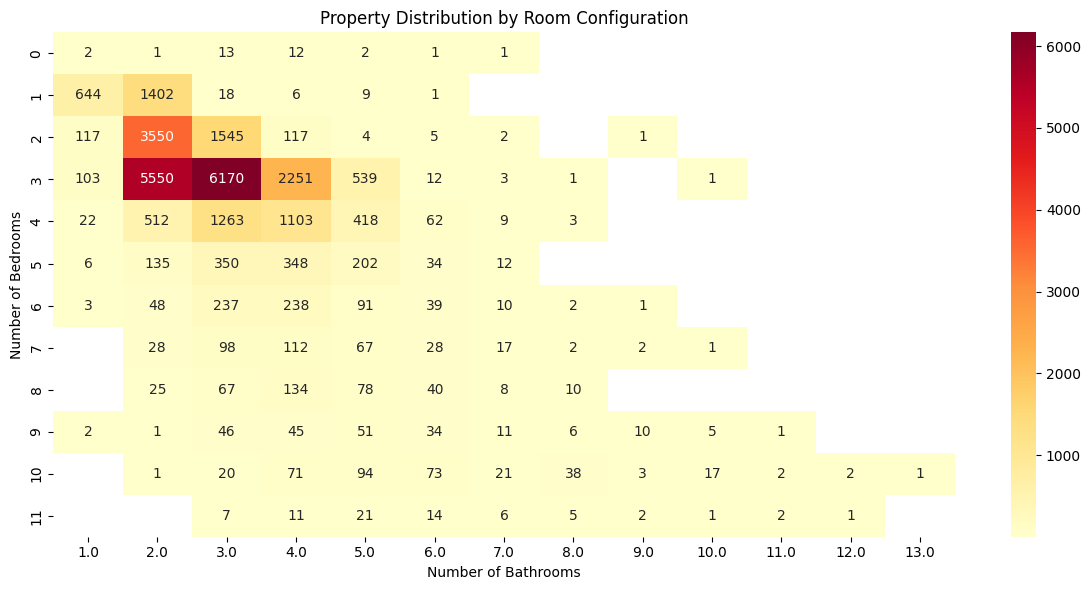

In [15]:
# 5. Price per Square Meter Analysis
data['price_per_m2'] = data['price'] / data['surface_total']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Distribution of price per m²
sns.histplot(data=data, x='price_per_m2', bins=50, ax=axes[0])
axes[0].set_title('Distribution of Price per m²')
axes[0].set_xlabel('Price per m²')

# Box plot of price per m² by property type
sns.boxplot(data=data, x='property_type', y='price_per_m2', ax=axes[1])
axes[1].set_title('Price per m² by Property Type')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# 6. Room Configuration Analysis
plt.figure(figsize=(12, 6))
room_config = data.groupby(['bedrooms', 'bathrooms']).size().reset_index()
room_config.columns = ['bedrooms', 'bathrooms', 'count']
pivot_table = room_config.pivot(index='bedrooms', columns='bathrooms', values='count')

sns.heatmap(pivot_table, annot=True, fmt='g', cmap='YlOrRd')
plt.title('Property Distribution by Room Configuration')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Number of Bedrooms')
plt.tight_layout()
plt.show()

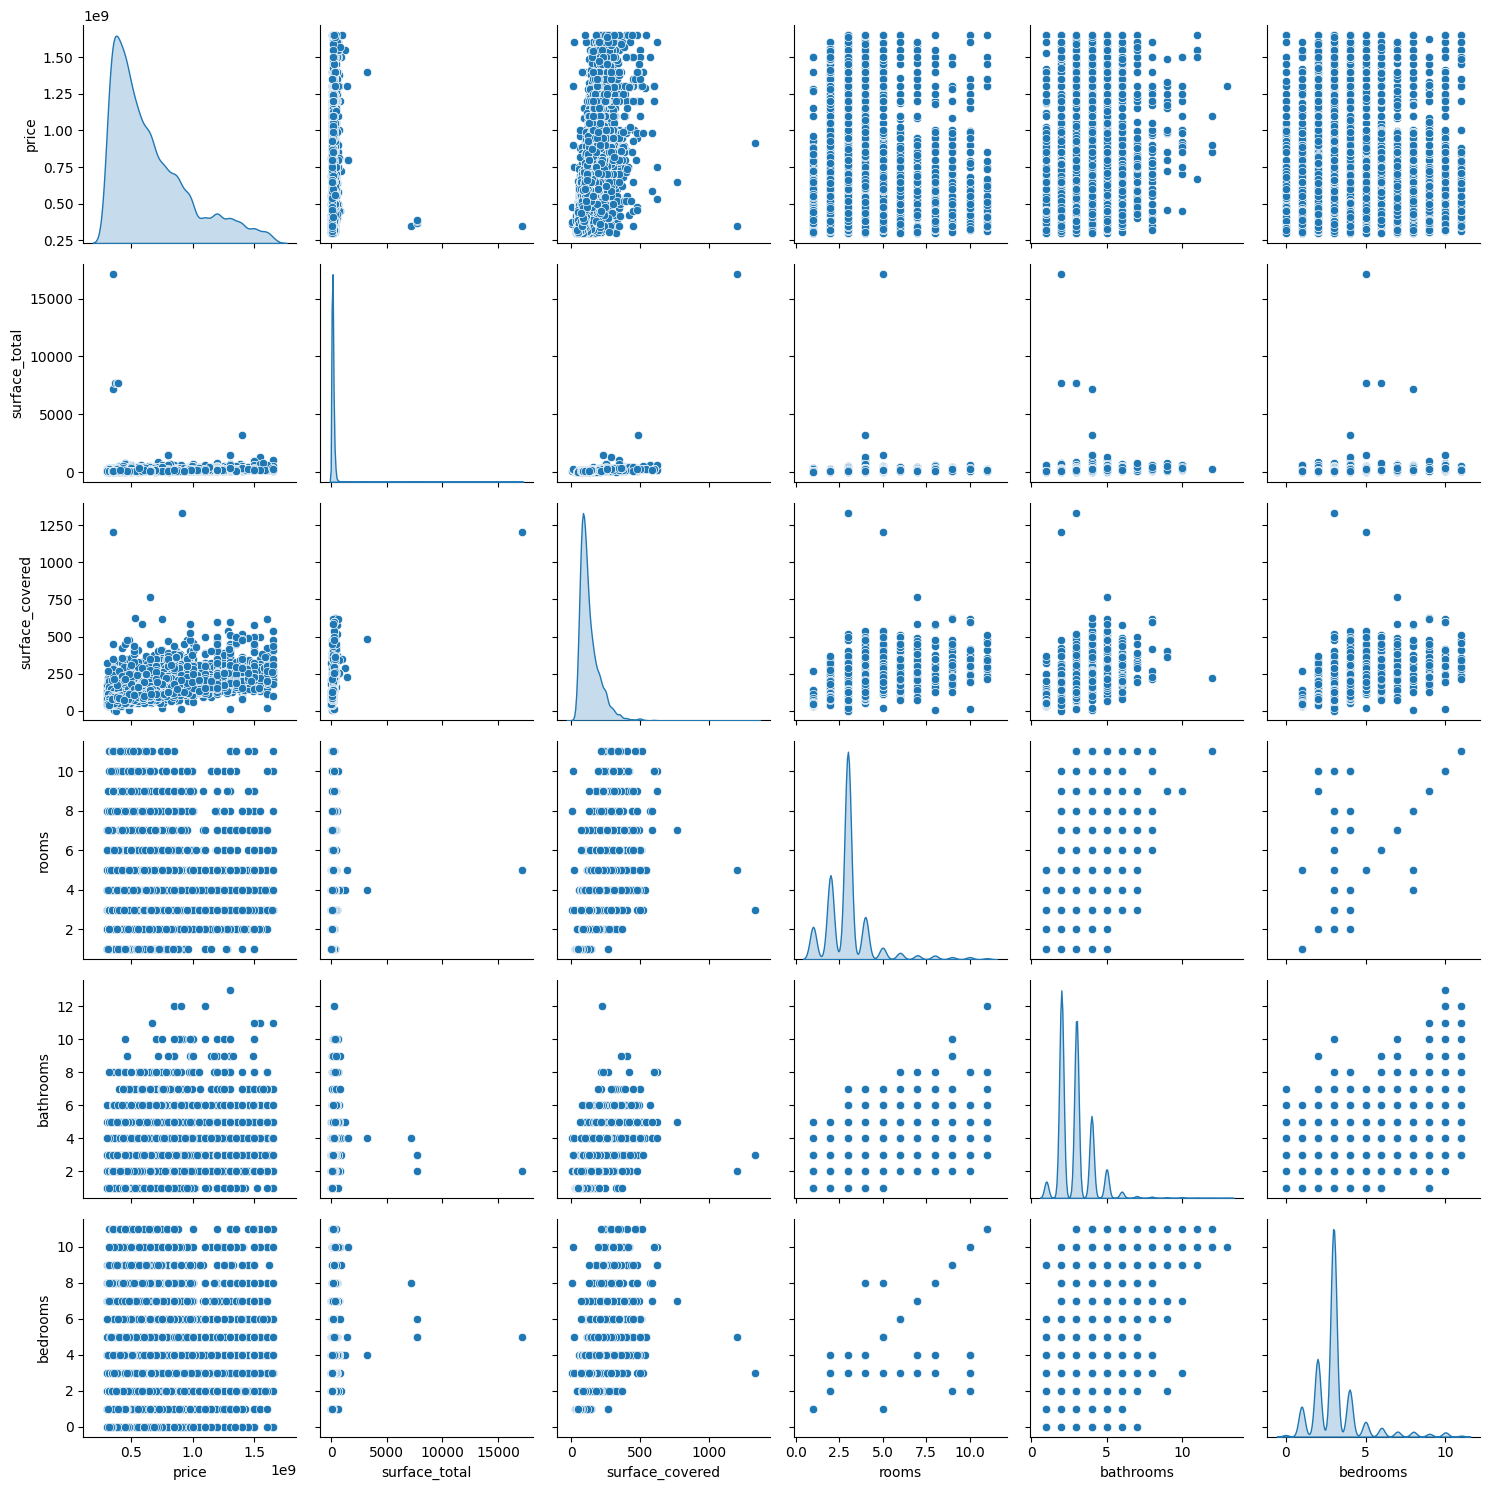


Summary Statistics by Property Type:
               price                                          surface_total  \
               count          mean       median           std          mean   
property_type                                                                 
Apartamento    29177  6.220662e+08  530000000.0  2.955581e+08        111.60   
Casa            9467  7.546016e+08  690000000.0  3.367466e+08        234.71   

                     rooms price_per_m2  
              median  mean         mean  
property_type                            
Apartamento     98.0  2.62   5671393.77  
Casa           200.0  4.66   3866604.87  


In [16]:
# 8. Feature Relationships Grid
numeric_cols = ['price', 'surface_total', 'surface_covered', 'rooms', 'bathrooms', 'bedrooms']
sns.pairplot(data[numeric_cols], diag_kind='kde')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Property Type:")
summary_stats = data.groupby('property_type').agg({
    'price': ['count', 'mean', 'median', 'std'],
    'surface_total': ['mean', 'median'],
    'rooms': 'mean',
    'price_per_m2': 'mean'
}).round(2)
print(summary_stats)

# 2. Feature Engineering

## 2.1. Text Features

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import spacy
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [18]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/edmundoarias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edmundoarias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def clean_text(text):
    """Clean and normalize text data."""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', ' ', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    return ''

In [20]:
def extract_numeric_features(text):
    """Extract numeric values with their associated words."""
    if not isinstance(text, str):
        return {}
    
    # Common patterns to look for
    patterns = {
        'bathrooms': r'(\d+)\s*(?:ba[ñn]os?|bath)',
        'bedrooms': r'(\d+)\s*(?:habitaciones|alcobas|dormitorios|recamaras)',
        'parking': r'(\d+)\s*(?:parqueaderos?|garajes?|parking)',
        'floor': r'piso\s*(\d+)',
        'area': r'(\d+)\s*(?:m2|metros?)',
        'deposits': r'(\d+)\s*(?:depositos?|bodegas?)',
    }
    
    features = {}
    for feature, pattern in patterns.items():
        matches = re.findall(pattern, text.lower())
        if matches:
            features[feature] = int(matches[0])
    
    return features

def extract_boolean_features(text):
    """Extract boolean features based on presence of keywords."""
    if not isinstance(text, str):
        return {}
    
    # Define feature keywords
    feature_keywords = {
        'has_balcony': ['balcon', 'balcón', 'terraza'],
        'has_gym': ['gimnasio', 'gym'],
        'has_pool': ['piscina', 'alberca'],
        'has_security': ['seguridad', 'vigilancia', 'cctv', 'conjunto cerrado'],
        'has_parking': ['parqueadero', 'garaje', 'parking'],
        'is_remodeled': ['remodelad', 'renovad'],
        'has_elevator': ['ascensor', 'elevador'],
        'has_storage': ['deposito', 'bodega', 'storage'],
        'has_view': ['vista', 'panorámica'],
        'has_bbq': ['bbq', 'barbecue', 'parrilla'],
        'is_exterior': ['exterior'],
        'has_garden': ['jardin', 'jardín', 'zonas verdes'],
        'has_playground': ['parque infantil', 'juegos infantiles'],
        'has_social_areas': ['salon social', 'salón social', 'areas comunes'],
    }
    
    text = text.lower()
    features = {}
    
    for feature, keywords in feature_keywords.items():
        features[feature] = int(any(keyword in text for keyword in keywords))
    
    return features

In [21]:
def extract_location_features(text):
    """Extract location-related features."""
    if not isinstance(text, str):
        return {}
    
    location_keywords = {
        'near_park': ['parque', 'zona verde'],
        'near_transport': ['transporte', 'transmilenio', 'bus', 'estación'],
        'near_shopping': ['centro comercial', 'comercio', 'mall', 'tiendas'],
        'near_schools': ['colegio', 'escuela', 'universidad'],
        'near_restaurants': ['restaurantes', 'zona gastronómica'],
    }
    
    text = text.lower()
    features = {}
    
    for feature, keywords in location_keywords.items():
        features[feature] = int(any(keyword in text for keyword in keywords))
    
    return features

In [22]:
def create_nlp_features(data):
    """Create all NLP features for the dataset."""
    # Initialize new features dictionary
    new_features = {}
    
    # Clean descriptions
    descriptions = data['description'].apply(clean_text)
    
    # Extract all feature types
    for idx, desc in descriptions.items():
        # Get all features
        numeric = extract_numeric_features(desc)
        boolean = extract_boolean_features(desc)
        location = extract_location_features(desc)
        
        # Combine all features
        all_features = {**numeric, **boolean, **location}
        
        # Add to new_features dictionary
        for feature, value in all_features.items():
            if feature not in new_features:
                new_features[feature] = pd.Series(index=data.index, dtype=object)
            new_features[feature][idx] = value
    
    # Create new DataFrame with extracted features
    features_df = pd.DataFrame(new_features)
    
    # Fill NaN values
    features_df = features_df.fillna(0)
    
    return features_df

In [23]:
new_features = create_nlp_features(data)
data = pd.concat([data, new_features], axis=1)

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/1751250374.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df = features_df.fillna(0)


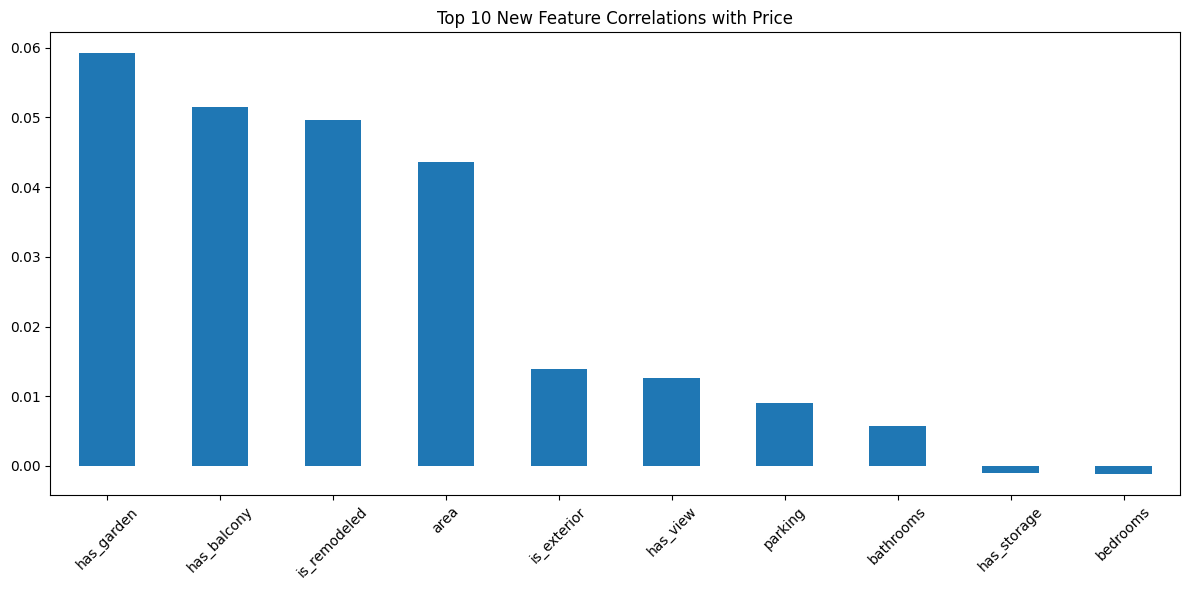

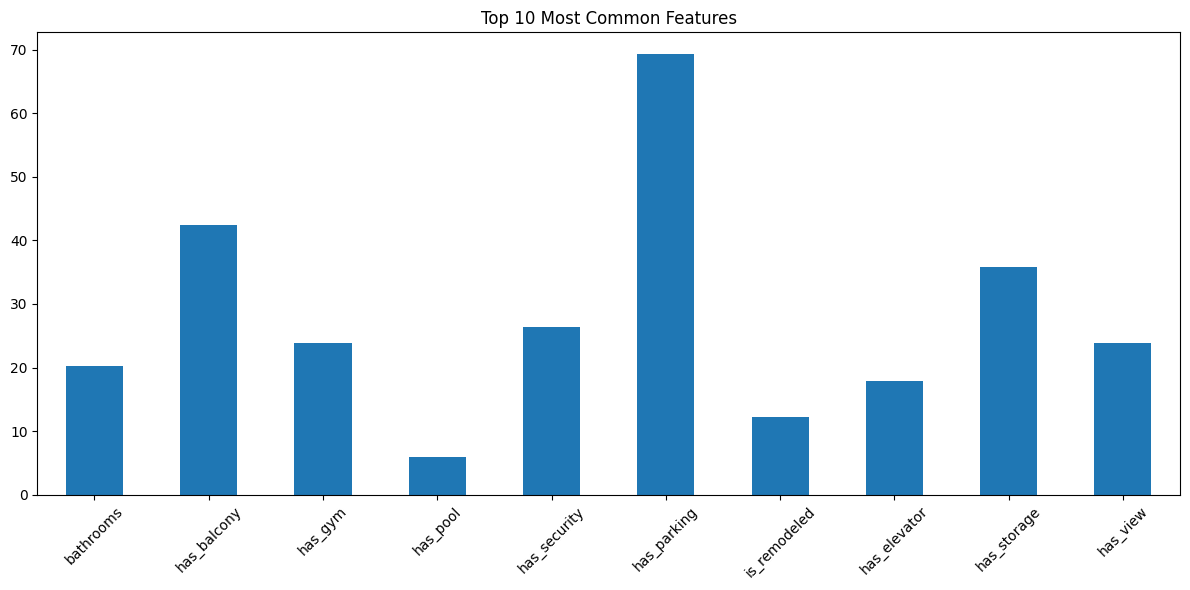

In [24]:
feature_presence = (new_features != 0).sum() / len(new_features) * 100
correlations = new_features.corrwith(data['price']).sort_values(ascending=False)

# top feature correlations with price
plt.figure(figsize=(12, 6))
correlations.head(10).plot(kind='bar')
plt.title('Top 10 New Feature Correlations with Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot feature presence
plt.figure(figsize=(12, 6))
feature_presence.head(10).plot(kind='bar')
plt.title('Top 10 Most Common Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.2. External Sources

In [25]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import time

In [26]:
ox.config(use_cache=False, log_console=False)

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/1443367404.py:1: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=False, log_console=False)


In [27]:
# sample_data = data.sample(100, random_state=42)

In [28]:
from shapely.geometry import box

def create_grid(bounds, grid_size):
    """
    Create a grid of polygons over the specified bounds.
    """
    minx, miny, maxx, maxy = bounds
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    
    grid_polygons = []
    for x in x_coords:
        for y in y_coords:
            grid_polygons.append(box(x, y, x + grid_size, y + grid_size))
    
    return gpd.GeoDataFrame({'geometry': grid_polygons}, crs='EPSG:4326')

# Calculate bounds of your area
min_lon, min_lat, max_lon, max_lat = (
    data['lon'].min(), data['lat'].min(), data['lon'].max(), data['lat'].max()
)

# def grid size in degrees
grid_size_deg = 0.01  # approx 1 km at the equator

# Create grid
grid = create_grid((min_lon, min_lat, max_lon, max_lat), grid_size_deg)


In [29]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
from shapely.geometry import Point, Polygon, box
from tqdm import tqdm
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def test_osm_query(lat, lon):
    """
    Test a single OSM query and print detailed feedback.
    """
    print(f"Testing OSM query for coordinates: ({lat}, {lon})")
    
    try:
        # Test a simple amenity query
        tags = {'amenity': 'school'}
        print("Attempting to fetch schools nearby...")
        features = ox.features_from_point((lat, lon), tags=tags, dist=1000)
        print(f"Success! Found {len(features)} schools nearby")
        return True
    except Exception as e:
        print(f"Error during OSM query: {str(e)}")
        return False

# First, let's test with just one property to make sure the connection works
print("Testing with first property in dataset...")
first_property = data.iloc[0]
print(f"Property coordinates: ({first_property['lat']}, {first_property['lon']})")

# Test the connection
test_result = test_osm_query(first_property['lat'], first_property['lon'])

if test_result:
    print("\nOSM connection successful! You can proceed with the full feature extraction.")
else:
    print("\nThere seems to be an issue with the OSM connection. Please check your coordinates and internet connection.")

from functools import lru_cache

@lru_cache(maxsize=None)
def get_area_features(north, south, east, west, tag_key, tag_value):
    try:
        tags = {tag_key: tag_value}
        features = ox.features_from_bbox(
            north=north,
            south=south,
            east=east,
            west=west,
            tags=tags
        )
        features = features.set_crs('EPSG:4326', allow_override=True)
        return features
    except Exception as e:
        print(f"Error fetching {tag_key}={tag_value}: {str(e)}")
        return gpd.GeoDataFrame()


def create_grid(bounds, cell_size_deg):
    """
    Create a grid of polygons over the specified bounds.
    """
    minx, miny, maxx, maxy = bounds
    x_coords = np.arange(minx, maxx, cell_size_deg)
    y_coords = np.arange(miny, maxy, cell_size_deg)
    
    grid_polygons = []
    for x in x_coords:
        for y in y_coords:
            grid_polygons.append(box(x, y, x + cell_size_deg, y + cell_size_deg))
    
    return gpd.GeoDataFrame({'geometry': grid_polygons}, crs='EPSG:4326')

def process_property_batch(properties, features_dict, max_distance=500):
    """
    Process a batch of properties against pre-fetched features.
    Ensures zeros are set when no features are found.
    """
    results = []

    # Define the projected CRS (MAGNA-SIRGAS / Colombia Bogotá zone)
    projected_crs = 'EPSG:3116'  # Suitable for Bogotá

    # Create GeoDataFrame for property points with initial CRS
    properties_gdf = gpd.GeoDataFrame(
        properties, 
        geometry=gpd.points_from_xy(properties['lon'], properties['lat']),
        crs='EPSG:4326'
    )

    # Project properties to the projected CRS
    properties_gdf = properties_gdf.to_crs(projected_crs)

    for idx, property_row in properties_gdf.iterrows():
        property_point = property_row['geometry']
        property_features = {}
        
        for tag_type, features in features_dict.items():
            if len(features) > 0:
                # Calculate distances in meters
                distances = features.geometry.distance(property_point)
                count = len(distances[distances <= max_distance])
                min_dist = distances.min() if count > 0 else max_distance
                
                property_features[f'count_{tag_type}'] = count
                property_features[f'dist_{tag_type}'] = min_dist
            else:
                # Ensure zeros are set when no features are found
                property_features[f'count_{tag_type}'] = 0
                property_features[f'dist_{tag_type}'] = max_distance  # Or a suitable default value

        results.append(property_features)
    
    return pd.DataFrame(results)


def extract_osm_features(df, max_distance=500):
    """
    Extract OSM features using a grid-based approach to stay within API limits.
    """
    # Define the projected CRS (MAGNA-SIRGAS / Colombia Bogotá zone)
    projected_crs = 'EPSG:3116'  # Suitable for Bogotá

    # Complete list of tags for Bogotá
    tags_list = [
        ('amenity', 'school'),
        ('amenity', 'hospital'),
        ('amenity', 'restaurant'),
        ('amenity', 'bank'),
        ('highway', 'bus_stop'),
        ('shop', 'supermarket'),
        ('leisure', 'park'),
        ('landuse', 'commercial')
    ]

    # Calculate bounds of your dataset
    min_lon, min_lat, max_lon, max_lat = (
        df['lon'].min(), df['lat'].min(), df['lon'].max(), df['lat'].max()
    )

    # Calculate degree size that corresponds to approximately 50 km²
    # At Bogotá's latitude (~4.7° N), 1 degree of latitude is ~110.6 km
    mean_latitude = df['lat'].mean()
    meters_per_degree_lat = 110574
    meters_per_degree_lon = 111320 * np.cos(np.radians(mean_latitude))

    # Area per grid cell (adjust to be under the Overpass API limit of 50 km²)
    cell_area_sqm = 49e6  # 45,000,000 square meters to stay under the limit
    cell_size_deg_lat = np.sqrt(cell_area_sqm) / meters_per_degree_lat
    cell_size_deg_lon = np.sqrt(cell_area_sqm) / meters_per_degree_lon

    # Use the smaller of the two to ensure area is within limits
    cell_size_deg = min(cell_size_deg_lat, cell_size_deg_lon)

    # Create grid
    grid = create_grid((min_lon, min_lat, max_lon, max_lat), cell_size_deg)

    print("Processing properties in grid cells...")
    all_results = []
    processed_properties = 0

    for idx, cell in tqdm(grid.iterrows(), total=grid.shape[0], desc="Processing grid cells"):
        cell_bounds = cell['geometry'].bounds  # (minx, miny, maxx, maxy)
        cell_properties = df[
            (df['lon'] >= cell_bounds[0]) & (df['lon'] <= cell_bounds[2]) &
            (df['lat'] >= cell_bounds[1]) & (df['lat'] <= cell_bounds[3])
        ]
        if cell_properties.empty:
            continue  # Skip cells without properties

        # Add buffer to cell bounds for fetching nearby features
        buffer_deg_lat = (max_distance / meters_per_degree_lat)
        buffer_deg_lon = (max_distance / meters_per_degree_lon)
        north = cell_bounds[3] + buffer_deg_lat  # maxy + buffer
        south = cell_bounds[1] - buffer_deg_lat  # miny - buffer
        east = cell_bounds[2] + buffer_deg_lon   # maxx + buffer
        west = cell_bounds[0] - buffer_deg_lon   # minx - buffer

        # Fetch features within this cell
        features_dict = {}
        for tag_key, tag_value in tags_list:
            feature_name = f"{tag_key}_{tag_value}"
            features = get_area_features(
                north=north,
                south=south,
                east=east,
                west=west,
                tag_key=tag_key, 
                tag_value=tag_value
            )
            if len(features) > 0:
                features = features.set_crs('EPSG:4326', allow_override=True)
                features_dict[feature_name] = features.to_crs(projected_crs)
            else:
                features_dict[feature_name] = gpd.GeoDataFrame()
            time.sleep(0.5)  # To avoid hitting rate limits

        # Process properties in this cell
        batch_results = process_property_batch(cell_properties, features_dict, max_distance)
        all_results.append(batch_results)
        processed_properties += len(cell_properties)

    # Combine results
    osm_features = pd.concat(all_results, ignore_index=True)

    # Calculate accessibility scores
    for col in osm_features.columns:
        if col.startswith('dist_'):
            osm_features[f'{col}_score'] = 1 / (1 + osm_features[col]/max_distance)

    print(f"Processed {processed_properties} properties.")
    return osm_features

def merge_and_save_features(original_data, osm_features, max_distance=500, filename=None):
    """
    Merge OSM features with original data and save the complete dataset.
    Fills missing values after merging and ensures data alignment.
    """
    # Ensure the index alignment is correct
    osm_features.index = original_data.index[:len(osm_features)]
    
    # Merge original data with new features
    complete_data = pd.concat([original_data.iloc[:len(osm_features)].reset_index(drop=True), osm_features], axis=1)
    
    # Fill missing values in counts with 0 and in distances with max_distance
    for col in osm_features.columns:
        if col.startswith('count_'):
            complete_data[col].fillna(0, inplace=True)
        elif col.startswith('dist_'):
            complete_data[col].fillna(max_distance, inplace=True)
        elif col.endswith('_score'):
            # For accessibility scores, fill NaNs with 0
            complete_data[col].fillna(0, inplace=True)

    # Generate filename if not provided
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'bogota_properties_with_osm_{timestamp}.csv'
    
    # Save to CSV
    complete_data.to_csv(filename, index=False)
    print(f"\nComplete dataset saved to: {filename}")
    
    # Print summary statistics
    print("\nFeature Summary:")
    print(f"Original columns: {len(original_data.columns)}")
    print(f"Added OSM features: {len(osm_features.columns)}")
    print(f"Total columns: {len(complete_data.columns)}")
    
    print("\nOSM Features with non-zero values:")
    for col in osm_features.columns:
        if col.startswith('count_'):
            non_zero = (complete_data[col] > 0).sum()
            print(f"{col}: {non_zero} properties ({(non_zero/len(complete_data)*100):.1f}%)")
    
    return complete_data

Testing with first property in dataset...
Property coordinates: (4.7072107, -74.0996451)
Testing OSM query for coordinates: (4.7072107, -74.0996451)
Attempting to fetch schools nearby...
Success! Found 24 schools nearby

OSM connection successful! You can proceed with the full feature extraction.


In [30]:
# Extract OSM features for the sample data
osm_features = extract_osm_features(data, max_distance=300)
complete_data = merge_and_save_features(data, osm_features)

Processing properties in grid cells...


Processing grid cells:   0%|          | 0/9 [00:00<?, ?it/s]/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.f

Error fetching amenity=hospital: No data elements in server response. Check log and query location/tags.


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0

Error fetching amenity=bank: No data elements in server response. Check log and query location/tags.


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  features = ox.features_from_bbox(


Error fetching highway=bus_stop: No data elements in server response. Check log and query location/tags.


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  features = ox.features_from_bbox(


Error fetching shop=supermarket: No data elements in server response. Check log and query location/tags.


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  features = ox.features_from_bbox(


Error fetching leisure=park: No data elements in server response. Check log and query location/tags.


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  features = ox.features_from_bbox(


Error fetching landuse=commercial: No data elements in server response. Check log and query location/tags.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyproj/transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
Processing grid cells:  78%|███████▊  | 7/9 [03:22<00:56, 28.41s/it]/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, 

Processed 38644 properties.

Complete dataset saved to: bogota_properties_with_osm_20241107_090246.csv

Feature Summary:
Original columns: 43
Added OSM features: 24
Total columns: 67

OSM Features with non-zero values:
count_amenity_school: 16619 properties (43.0%)
count_amenity_hospital: 7889 properties (20.4%)
count_amenity_restaurant: 28952 properties (74.9%)
count_amenity_bank: 18730 properties (48.5%)
count_highway_bus_stop: 30197 properties (78.1%)
count_shop_supermarket: 26758 properties (69.2%)
count_leisure_park: 36755 properties (95.1%)
count_landuse_commercial: 7380 properties (19.1%)


In [31]:
# store data ready for model
complete_data.to_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/train_ready.csv', index=False)

In [32]:
#TODO: exact same thing but now with the test data :)

In [33]:
test = pd.read_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/raw/test.csv')
test.columns

# remove price column
test = test.drop(columns=['price'])

In [34]:
def create_test_features(test_data):
    """
    Create the same features for test data as we did for training data.
    
    Parameters:
    -----------
    test_data : pd.DataFrame
        Test dataset (without price column)
    """
    # 1. Text-based features
    print("Extracting text features...")
    new_features = {}
    
    # Clean descriptions and extract features
    descriptions = test_data['description'].apply(clean_text)
    
    for idx, desc in descriptions.items():
        # Get all features
        numeric = extract_numeric_features(desc)
        boolean = extract_boolean_features(desc)
        location = extract_location_features(desc)
        
        # Combine all features
        all_features = {**numeric, **boolean, **location}
        
        # Add to new_features dictionary
        for feature, value in all_features.items():
            if feature not in new_features:
                new_features[feature] = pd.Series(index=test_data.index, dtype=object)
            new_features[feature][idx] = value
    
    # Create features DataFrame
    features_df = pd.DataFrame(new_features)
    features_df = features_df.fillna(0)
    
    # 2. OSM features
    print("\nExtracting OSM features...")
    osm_features = extract_osm_features(test_data, max_distance=300)
    
    # 3. Combine all features with original data
    print("\nCombining features...")
    test_data_with_features = pd.concat([test_data, features_df, osm_features], axis=1)
    
    # Save the results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'test_data_with_features_{timestamp}.csv'
    test_data_with_features.to_csv(filename, index=False)
    
    print(f"\nProcessed test data saved to: {filename}")
    print(f"Number of added features: {len(features_df.columns) + len(osm_features.columns)}")
    
    return test_data_with_features


In [35]:
# Usage:
test_data_processed = create_test_features(test)

Extracting text features...


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/407060089.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df = features_df.fillna(0)



Extracting OSM features...
Processing properties in grid cells...


Processing grid cells:   0%|          | 0/6 [00:00<?, ?it/s]/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  features = ox.features_from_bbox(
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/4155737854.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  features = ox.f

Processed 10286 properties.

Combining features...

Processed test data saved to: test_data_with_features_20241107_090433.csv
Number of added features: 49


In [36]:
# remove duplicate columns 
complete_data = complete_data.loc[:,~complete_data.columns.duplicated()]

In [37]:
print(f"Training data shape: {complete_data.shape}")
print(f"Test data shape: {test_data_processed.shape}")

Training data shape: (38644, 65)
Test data shape: (10286, 64)


### Imputation
let's impute missing values based on 

In [38]:
# print columns with missign values
print("\nColumns with missing values:")
missing_values = complete_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)


Columns with missing values:
surface_total      30790
surface_covered    30079
rooms              18260
bathrooms          10071
title                 25
description           12
price_per_m2       30790
dtype: int64


In [39]:
def impute_missing_values(df):
    """
    Impute missing values based on price ranges and property characteristics
    """
    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Create price ranges for more accurate imputation
    data['price_range'] = pd.qcut(data['price'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    
    # Group by property type and price range for more accurate medians
    grouping_cols = ['property_type', 'price_range']
    
    # Dictionary to store imputation strategies
    impute_cols = {
        'surface_total': 'median',
        'surface_covered': 'median',
        'rooms': 'median',
        'bathrooms': 'median'
    }
    
    # First imputation: By property type and price range
    for col, strategy in impute_cols.items():
        # Calculate medians for each group
        group_medians = data.groupby(grouping_cols)[col].agg(strategy)
        
        # Create a mapping dictionary for imputation
        impute_dict = {
            idx: value for idx, value in group_medians.items()
        }
        
        # Impute missing values
        missing_mask = data[col].isna()
        for (prop_type, price_range), value in impute_dict.items():
            mask = (missing_mask & 
                   (data['property_type'] == prop_type) & 
                   (data['price_range'] == price_range))
            data.loc[mask, col] = value
        
        # Second pass: Impute remaining missing values by property type only
        still_missing = data[col].isna()
        if still_missing.any():
            type_medians = data.groupby('property_type')[col].agg(strategy)
            for prop_type, value in type_medians.items():
                mask = (still_missing & (data['property_type'] == prop_type))
                data.loc[mask, col] = value
        
        # Final pass: Use overall median for any remaining missing values
        if data[col].isna().any():
            data[col] = data[col].fillna(data[col].median())
    
    # For text columns, use simple string imputation
    data['title'] = data['title'].fillna('No Title')
    data['description'] = data['description'].fillna('No Description')
    
    # Recalculate price_per_m2 after imputing surface_total
    data['price_per_m2'] = data['price'] / data['surface_total']
    
    # Drop the temporary price_range column
    data = data.drop('price_range', axis=1)
    
    return data

# Add some validation checks
def validate_imputation(original_df, imputed_df):
    """
    Validate the imputation results
    """
    print("Validation Report:")
    print("-----------------")
    
    # Check remaining missing values
    print("\nRemaining missing values:")
    print(imputed_df.isnull().sum()[imputed_df.isnull().sum() > 0])
    
    # Check basic statistics before and after imputation
    for col in ['surface_total', 'surface_covered', 'rooms', 'bathrooms']:
        print(f"\n{col} statistics:")
        print("Before:")
        print(original_df[col].describe())
        print("\nAfter:")
        print(imputed_df[col].describe())
        
    # Check correlations with price
    print("\nCorrelations with price:")
    cols_to_check = ['surface_total', 'surface_covered', 'rooms', 'bathrooms', 'price_per_m2']
    for col in cols_to_check:
        before_corr = original_df[['price', col]].corr().iloc[0,1]
        after_corr = imputed_df[['price', col]].corr().iloc[0,1]
        print(f"{col}: Before = {before_corr:.3f}, After = {after_corr:.3f}")

# Usage:
imputed_data = impute_missing_values(complete_data)
validate_imputation(complete_data, imputed_data)

Validation Report:
-----------------

Remaining missing values:
Series([], dtype: int64)

surface_total statistics:
Before:
count     7854.000000
mean       153.950216
std        274.370273
min         16.000000
25%         84.000000
50%        119.000000
75%        185.000000
max      17137.000000
Name: surface_total, dtype: float64

After:
count    38644.000000
mean       134.254710
std        133.223202
min         16.000000
25%         85.000000
50%        106.000000
75%        180.500000
max      17137.000000
Name: surface_total, dtype: float64

surface_covered statistics:
Before:
count    8565.000000
mean      131.932399
std        76.616355
min         2.000000
25%        81.000000
50%       108.000000
75%       160.000000
max      1336.000000
Name: surface_covered, dtype: float64

After:
count    38644.000000
mean       132.336844
std         61.946287
min          2.000000
25%         86.000000
50%        113.000000
75%        178.000000
max       1336.000000
Name: surface_cov

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/1243981614.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_medians = data.groupby(grouping_cols)[col].agg(strategy)
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/1243981614.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_medians = data.groupby(grouping_cols)[col].agg(strategy)
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_13663/1243981614.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

In [40]:
## now for test
print("\nColumns with missing values:")
missing_values = test_data_processed.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)



Columns with missing values:
surface_total      8422
surface_covered    7459
rooms              4582
bathrooms          2491
title                 6
description           3
dtype: int64


In [41]:
def impute_test_missing_values(df):
    """
    Impute missing values based on property type characteristics for test data
    """
    # Create a deep copy
    data = df.copy(deep=True)
    
    # Reset index
    data = data.reset_index(drop=True)
    
    # Simple imputation for text columns first
    data['title'] = data['title'].fillna('No Title')
    data['description'] = data['description'].fillna('No Description')
    
    # Numeric columns to impute
    numeric_cols = ['surface_total', 'surface_covered', 'rooms', 'bathrooms']
    
    # For each numeric column
    for col in numeric_cols:
        # Get median values per property type
        medians = data.groupby('property_type')[col].transform('median')
        
        # Fill with property type medians first
        data[col] = data[col].fillna(medians)
        
        # Fill any remaining NAs with overall median
        data[col] = data[col].fillna(data[col].median())
    
    return data

def validate_test_imputation(original_df, imputed_df):
    """
    Validate the imputation results for test data
    """
    print("Test Data Validation Report:")
    print("-----------------")
    
    print("\nMissing values before imputation:")
    print(original_df.isnull().sum()[original_df.isnull().sum() > 0])
    
    print("\nMissing values after imputation:")
    print(imputed_df.isnull().sum()[imputed_df.isnull().sum() > 0])
    
    for col in ['surface_total', 'surface_covered', 'rooms', 'bathrooms']:
        print(f"\n{col} statistics:")
        print("Before:")
        print(original_df[col].describe().round(2))
        print("\nAfter:")
        print(imputed_df[col].describe().round(2))

# Usage:
imputed_test_data = impute_test_missing_values(test_data_processed)
validate_test_imputation(test_data_processed, imputed_test_data)

# Print shapes to verify
print("\nShape before:", test_data_processed.shape)
print("Shape after:", imputed_test_data.shape)

Test Data Validation Report:
-----------------

Missing values before imputation:
surface_total      8422
surface_covered    7459
rooms              4582
bathrooms          2491
title                 6
description           3
dtype: int64

Missing values after imputation:
Series([], dtype: int64)

surface_total statistics:
Before:
count      1864.00
mean        187.94
std        2517.99
min          15.00
25%          84.00
50%         120.00
75%         160.00
max      108800.00
Name: surface_total, dtype: float64

After:
count     10286.00
mean        131.18
std        1072.00
min          15.00
25%         118.00
50%         118.00
75%         118.00
max      108800.00
Name: surface_total, dtype: float64

surface_covered statistics:
Before:
count    2827.00
mean      126.21
std        57.51
min        31.00
25%        82.00
50%       118.00
75%       160.00
max       505.00
Name: surface_covered, dtype: float64

After:
count    10286.00
mean       122.63
std         33.92
min       

In [42]:
# store datasets ready for model
imputed_data.to_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/train_ready.csv', index=False)
imputed_test_data.to_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/test_ready.csv', index=False)